# Bio-BERT Transformer Trainer


## Set Up

In [1]:
# !pip install transformers datasets accelerate evaluate gensim==4.2.0 numpy==1.22.4 rdkit==2023.3.1

In [58]:
!pwd

/home/ubuntu/capstone-project


In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# cd drive/MyDrive/w210_Capstone/
%cd ..

/home/ubuntu/capstone-project


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, AutoConfig
from transformers import AdamW, get_cosine_schedule_with_warmup
from transformers import BertConfig, BertModel
from datasets import load_metric, load_dataset

import gensim
import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

# from logging import warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
if torch.cuda.is_available():
    device = "cuda"
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = "cpu"

Number of GPU(s) available: 1
GPU device name: NVIDIA A10G


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
RANDOM_SEED = 40
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

## Bio-BERT with Trainer & Hugging Face

### Build DataSet

In [6]:
## Define hyperparameters
BATCH_SIZE = 32
EPOCHS = 4
# LEARNING_RATE = 1e-3
LEARNING_RATE = 0.01
# LEARNING_RATE = 0.0963
WEIGHT_DECAY = 1e-4
# WEIGHT_DECAY = 0.01
WORKERS = int(os.cpu_count())

In [7]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary.csv'
test_file = 'data/binary_ddi/ddi_test_binary.csv'

dataset = load_dataset('csv',
                       sep="\t",
                       data_files={'train': train_file, 'validation': dev_file,'test': test_file})

Found cached dataset csv (/home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 300000
    })
    validation: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 238072
    })
    test: Dataset({
        features: ['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity', 'smiles1', 'smiles2'],
        num_rows: 186753
    })
})

In [10]:
df_train = pd.read_csv(train_file, sep='\t')
df_dev = pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')
print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()

mean length of smiles1: 62.479706666666665
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.77145
min length of smiles2: 3
max length of smiles2: 748
Value Counts of Labels in Train Set:


interaction_type
1    150000
0    150000
Name: count, dtype: int64

In [8]:
## Load the pre-trained BioBERT tokenizer
# model_checkpoint = "dmis-lab/biobert-base-cased-v1.1"
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

# Tokenize & Pre-process Data
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [9]:
from transformers import PretrainedConfig

class BioClinicalBertConfig(PretrainedConfig):
    model_type = "bert"

    def __init__(
        self,
        hidden_size1: int = 68, 
        hidden_size2: int = 54, 
        hidden_size3: int = 40, 
        hidden3_dropout: float = 0.1, 
        unfreeze: bool = False,
        layer_norm_eps: float = 1e-12,
        pad_token_id: int = 0,
        position_embedding_type: str = "absolute",
        use_cache: bool = True,
        **kwargs,
    ):
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden3_dropout = hidden3_dropout
        self.unfreeze = unfreeze
        self.layer_norm_eps = layer_norm_eps
        self.pad_token_id = pad_token_id
        self.position_embedding_type = position_embedding_type
        self.use_cache = use_cache
        super().__init__(**kwargs)

config = BioClinicalBertConfig.from_pretrained(
    model_checkpoint,
    label2id={"NEGATIVE": 0, "POSITIVE": 1},
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    unfreeze=False,
    
)

In [10]:
print(config)

BioClinicalBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden3_dropout": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "hidden_size1": 68,
  "hidden_size2": 54,
  "hidden_size3": 40,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "unfreeze": false,
  "use_cache": true,
  "vocab_size": 28996
}



In [11]:
# Create Combined SMILES column, seperated by [SEP] token between SMILES1 & SMILES2
def preprocess_data(examples):
    source_inputs = []
    for sm1, sm2 in zip(examples['smiles1'], examples['smiles2']):
        # Ensure feeding both smile 1 & smiles 2 into input by truncating if the smiles are too loong
        source_input = "[CLS]" + sm1[:250] + "[SEP]" + sm2[:250] + "[SEP]"
        source_inputs.append(source_input)
    model_inputs = tokenizer(source_inputs,
                             max_length=512,
                             padding="max_length",
                             truncation=True,
                             return_token_type_ids=False,
                             return_tensors='pt'
                             )

    model_inputs["labels"] = examples['interaction_type']

    return model_inputs

In [12]:
encoded_train_ds = dataset['train'].map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
encoded_val_ds_full = dataset['validation'].map(preprocess_data, batched=True, remove_columns=dataset['validation'].column_names)
encoded_val_ds = encoded_val_ds_full.select(indices=range(30000))  # Subset to smaller valset for faster training
encoded_test_ds = dataset['test'].map(preprocess_data, batched=True, remove_columns=dataset['test'].column_names)

encoded_val_ds

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-302195fe960a0721.arrow


Map:   0%|          | 0/238072 [00:00<?, ? examples/s]

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/csv/default-7c7fda65b4fd85b3/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d/cache-88c4a77060bf653b.arrow


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 30000
})

In [13]:
encoded_val_ds[0]['labels']

1

In [15]:
len(encoded_train_ds)/BATCH_SIZE

2343.75

### Build Model, Set up Trainer

In [13]:
from transformers import BertPreTrainedModel, BertModel

class BioClinicalBertClassification(BertPreTrainedModel):
    config_class = BioClinicalBertConfig
    
    def __init__(self, config, num_labels=2):
        super(BioClinicalBertClassification, self).__init__(config)
        self.bert_model = BertModel(config=config)
        self.num_labels = num_labels

        # Unfreeze the last BERT transformer layer
        if config.unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if config.unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, config.hidden_size1)
        self.hidden_layer2 = nn.Linear(config.hidden_size1, config.hidden_size2)
        self.hidden_layer3 = nn.Linear(config.hidden_size2, config.hidden_size3)

        self.drop_out = nn.Dropout(config.hidden3_dropout)

        if self.num_labels >= 2:
            self.classification = nn.Linear(config.hidden_size3, self.num_labels)
        else:
            self.classification = nn.Linear(config.hidden_size3, 1)
            
        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)
        
        # pooler_token = bert_output[1]
        pooler_token = bert_output[0][:,0]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)      

        if self.num_labels >= 2:
            logits = self.classification(hidden_ouput)

        else:           
            logits = self.Sigmoid(self.classification(hidden_ouput))
            logits = logits.flatten()
        
        if self.num_labels == 1 and labels is not None:
            loss_fct = nn.BCELoss()
            loss = loss_fct(logits, labels.float())
            return {"loss": loss, "logits": logits}
        
        if self.num_labels >= 2 and labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

In [14]:
BioClinicalBertConfig.register_for_auto_class()
BioClinicalBertClassification.register_for_auto_class("AutoModelForSequenceClassification")

In [15]:
# Load Metric
metric = load_metric('glue', 'sst2')
metric

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

In [16]:
# Test metric calculation
fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.53125}

In [17]:
def compute_metrics(eval_pred, num_labels=2):
    predictions, labels = eval_pred
        
    if num_labels >= 2:
        # probability
        # softmax = np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
        # scores = softmax[:, 1]
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions =(np.array(predictions) >= 0.5).astype(float)
        # scores = np.array(predictions)

    # Accuracy
    result = metric.compute(predictions=predictions, references=labels)

    # Add F2 Score
    result["f2"] = metrics.fbeta_score(labels, predictions, average="binary", pos_label=1, beta=2)

    # Add Recall
    result["recall"] = metrics.recall_score(labels, predictions, average="binary", pos_label=1)

    # Add Precision
    result["precision"] = metrics.precision_score(labels, predictions, average="binary", pos_label=1)

    # Matthew Correlation
    result["mcc"] = metrics.matthews_corrcoef(labels, predictions)

    # Area Under Precision, Recall Curve
    # precisions, recalls, thresholds = precision_recall_curve(labels, scores)
    # result["AUPRC"] = auc(precisions, recalls)
    
    return {k: round(v, 4) for k, v in result.items()}

In [18]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [19]:
# Model Initilization
model = BioClinicalBertClassification(config)

# # Pretrain model weights
# pretrained_model = AutoModel.from_pretrained(model_checkpoint)
# # Load pre-train weights to BioBert model
# model.bert_model.load_state_dict(pretrained_model.state_dict())

# Load training weights checkpoint, for continue training
# pretrained_weights = torch.load('models/BioBERTFrozen.pth')
pretrained_weights = torch.load('models/Bio_ClinicalBERT_DDI_2heads2.pth')
model.load_state_dict(pretrained_weights )



# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_checkpoint, config=config
# )

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-20:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Optimizer & Schedular
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, 
#                   weight_decay=WEIGHT_DECAY)
# scheduler = get_cosine_schedule_with_warmup(optimizer,
#                                             num_warmup_steps=10,
#                                             num_training_steps=30000)

# Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = round(EPOCHS*len(encoded_train_ds)/BATCH_SIZE)
print('Number of steps:', T_max)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

bert_model.encoder.layer.11.attention.output.dense.weight   (768, 768)
bert_model.encoder.layer.11.attention.output.dense.bias       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.bias       (768,)
bert_model.encoder.layer.11.intermediate.dense.weight    (3072, 768)
bert_model.encoder.layer.11.intermediate.dense.bias          (3072,)
bert_model.encoder.layer.11.output.dense.weight          (768, 3072)
bert_model.encoder.layer.11.output.dense.bias                 (768,)
bert_model.encoder.layer.11.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.11.output.LayerNorm.bias             (768,)
bert_model.pooler.dense.weight                            (768, 768)
bert_model.pooler.dense.bias                                  (768,)
hidden_layer.weight                                        (68, 768)
hidden_layer.bias                                              (68,)
hidden_layer2.weight  

### Training with Trainer

In [20]:
# Training Arguments
model_dir = "Bio_ClinicalBERT_DDI_finetuned"

args = TrainingArguments(
    output_dir=model_dir,
    overwrite_output_dir=True,
    do_train=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    # evaluation_strategy="steps",
    # eval_steps=1000,
    # logging_strategy="steps",
    # logging_steps=1000,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=EPOCHS,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=True,
    push_to_hub=True,
)

In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_train_ds,
    eval_dataset=encoded_val_ds,
    tokenizer=tokenizer,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

/home/ubuntu/capstone-project/Bio_ClinicalBERT_DDI_finetuned is already a clone of https://huggingface.co/ltmai/Bio_ClinicalBERT_DDI_finetuned. Make sure you pull the latest changes with `repo.git_pull()`.


In [27]:
# Starting metrics from last checkpoint training
# EVALUATION BEFORE TRAINING
trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.683655321598053,
 'eval_accuracy': 0.5625,
 'eval_f2': 0.8649,
 'eval_recall': 0.9991,
 'eval_precision': 0.5626,
 'eval_mcc': -0.0005,
 'eval_runtime': 274.3033,
 'eval_samples_per_second': 109.368,
 'eval_steps_per_second': 1.71}

In [22]:
# TRANING
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F2,Recall,Precision,Mcc
1,0.678500,0.685292,0.555000,0.717400,0.762900,0.579400,0.057200
2,0.676800,0.686711,0.551900,0.688000,0.720800,0.582200,0.059800
3,0.677700,0.687498,0.550100,0.670300,0.696100,0.584000,0.061600
4,0.679000,0.687751,0.548200,0.658300,0.679800,0.584700,0.061200


We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

TrainOutput(global_step=37500, training_loss=0.6782601220703125, metrics={'train_runtime': 13325.0567, 'train_samples_per_second': 90.056, 'train_steps_per_second': 2.814, 'total_flos': 3.159425138688e+17, 'train_loss': 0.6782601220703125, 'epoch': 4.0})

### Evaluation

In [23]:
# EVALUATION AFTER TRAINING
trainer.evaluate(encoded_test_ds)

{'eval_loss': 0.6686776280403137,
 'eval_accuracy': 0.592,
 'eval_f2': 0.7169,
 'eval_recall': 0.7257,
 'eval_precision': 0.6836,
 'eval_mcc': 0.0495,
 'eval_runtime': 1703.9991,
 'eval_samples_per_second': 109.597,
 'eval_steps_per_second': 3.425,
 'epoch': 4.0}

In [24]:
trainer.push_to_hub()
#model.push_to_hub()

We can't save the code defining BioClinicalBertClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

'https://huggingface.co/ltmai/Bio_ClinicalBERT_DDI_finetuned/commit/18c5deeab17f9dcb4f1e422f1f1f76a077e69617'

In [ ]:
# save training weights
# trainer.save_pretrain('Bio_ClinicalBERT_DDI_finetuned')
torch.save(model.state_dict(), 'models/Bio_ClinicalBERT_DDI_2heads3.pth')

## Morgan300 & BioClinicalBERT SMILES & PATHWAY

### Build Model

In [5]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 60
LEARNING_RATE = 0.001
# MOMENTUM = 0.9
WEIGHT_DECAY = 0.01
WORKERS = int(os.cpu_count())

In [6]:
# BERT Model
class MorganBioBertClassification(nn.Module):
    def __init__(self,output_dim=1,
                 hidden_size=68, hidden_size2=54, hidden_size3=40,
                 dropout=0.1, unfreeze=False):
        super(MorganBioBertClassification, self).__init__()
        self.bert_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        # Unfreeze the last BERT transformer layer
        if unfreeze == "last layer":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "last two":
            for name, param in self.bert_model.named_parameters():
                if 'bert_model.encoder.layer.11' in name or 'bert_model.encoder.layer.10' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        if unfreeze == "all layers":
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.bert_model.named_parameters():
                param.requires_grad = False

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size2
        self.hidden_size3 = hidden_size3
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)
        self.hidden_layer2 = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3 = nn.Linear(self.hidden_size2, self.hidden_size3)

        # Morgan Embedding First hidden layer
        self.hidden_layer_morgan = nn.Linear(600, self.hidden_size)
        self.hidden_layer2_morgan = nn.Linear(self.hidden_size, self.hidden_size2)
        self.hidden_layer3_morgan = nn.Linear(self.hidden_size2, self.hidden_size3)

        # One hidden Layer after combining both branches
        self.hidden_layer_combine = nn.Linear(2*self.hidden_size3, 16)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(16, output_dim)

        self.GeLU = nn.GELU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, morgan_embedding):
        # Output for target data
        bert_output = self.bert_model(input_ids=input_ids,
                                      attention_mask=attention_mask)

        pooler_token = bert_output[1]

        hidden_ouput = self.GeLU(self.hidden_layer(pooler_token))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer2(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)
        hidden_ouput = self.GeLU(self.hidden_layer3(hidden_ouput))
        hidden_ouput = self.drop_out(hidden_ouput)

        # Output for SMILES Morgan Embedding
        hidden_morgan_output = self.GeLU(self.hidden_layer_morgan(morgan_embedding))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)
        hidden_morgan_output = self.GeLU(self.hidden_layer2_morgan(hidden_morgan_output))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)
        hidden_morgan_output = self.GeLU(self.hidden_layer3_morgan(hidden_morgan_output))
        hidden_morgan_output = self.drop_out(hidden_morgan_output)

        # Concatenate hidden_output and morgan_output
        concat_output = torch.cat((hidden_morgan_output, hidden_ouput), 1)
        hidden_concat_output = self.GeLU(self.hidden_layer_combine(concat_output))
        hidden_concat_output = self.drop_out(hidden_concat_output)

        # logits = self.classification(x)
        output = self.Sigmoid(self.classification(hidden_concat_output))
        output = output.flatten()

        # return logits
        return output

In [7]:
# Initialize model
model = MorganBioBertClassification()
model = model.to(device)

#load the pre-trained Bio-ClinicalBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Print out models params for checking
params = list(model.named_parameters())
for p in params[-30:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert_model.encoder.layer.11.attention.self.value.weight   (768, 768)
bert_model.encoder.layer.11.attention.self.value.bias         (768,)
bert_model.encoder.layer.11.attention.output.dense.weight   (768, 768)
bert_model.encoder.layer.11.attention.output.dense.bias       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.weight       (768,)
bert_model.encoder.layer.11.attention.output.LayerNorm.bias       (768,)
bert_model.encoder.layer.11.intermediate.dense.weight    (3072, 768)
bert_model.encoder.layer.11.intermediate.dense.bias          (3072,)
bert_model.encoder.layer.11.output.dense.weight          (768, 3072)
bert_model.encoder.layer.11.output.dense.bias                 (768,)
bert_model.encoder.layer.11.output.LayerNorm.weight           (768,)
bert_model.encoder.layer.11.output.LayerNorm.bias             (768,)
bert_model.pooler.dense.weight                            (768, 768)
bert_model.pooler.dense.bias                                  (768,)
hidden_layer.weight   

### Build DataLoader

In [8]:
# Import data
train_file = 'data/binary_ddi/ddi_train_balanced_pathway_150k.csv'
dev_file = 'data/binary_ddi/ddi_val_binary_pathway.csv'
test_file = 'data/binary_ddi/ddi_test_binary_pathway.csv'

df_train = pd.read_csv(train_file, sep='\t')
df_val= pd.read_csv(dev_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

print(f'''mean length of smiles1: {df_train['smiles1'].map(len).mean()}''')
print(f'''min length of smiles1: {df_train['smiles1'].map(len).min()}''')
print(f'''max length of smiles1: {df_train['smiles1'].map(len).max()}''')
print(f'''mean length of smiles2: {df_train['smiles2'].map(len).mean()}''')
print(f'''min length of smiles2: {df_train['smiles2'].map(len).min()}''')
print(f'''max length of smiles2: {df_train['smiles2'].map(len).max()}''')
print('Value Counts of Labels in Train Set:')
df_train.interaction_type.value_counts()
df_train.head(2)

mean length of smiles1: 62.47947666666666
min length of smiles1: 2
max length of smiles1: 748
mean length of smiles2: 62.731
min length of smiles2: 2
max length of smiles2: 748
Value Counts of Labels in Train Set:


,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
0,DB01501,DB00356,OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)...,ClC1=CC2=C(OC(=O)N2)C=C1,OC(=O)C1(CCN(CCC(C#N)(C2=CC=CC=C2)C2=CC=CC=C2)...,1,high
1,DB00208,DB00242,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2,NC1=C2N=CN([C@H]3C[C@H](O)[C@@H](CO)O3)C2=NC(C...,ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2 clopidogrel is...,1,high


In [9]:
from sklearn.utils import resample

# Choose a smaller subset of val data for faster training
df_val_small = resample(df_val,
                        replace=False,     # sample without replacement
                        n_samples=30000,
                        # random_state=1
                        )
print(df_val_small.shape)
df_val_small.head(2)

(30000, 7)


,d1,d2,smiles1,smiles2,smiles_pathway_features,interaction_type,severity
158351,DB11268,DB00681,[H]C(=O)C1=CC(O)=C(O)C=C1,[H][C@]12C[C@@H](O[C@@H]3O[C@H](C)[C@@H](O)[C@...,[H]C(=O)C1=CC(O)=C(O)C=C1 not available [SEP] ...,0,unknown
185430,DB09026,DB13852,COCCCOC1=C(OC)C=CC(C[C@@H](C[C@H](N)[C@@H](O)C...,CC(CC1=CC=CC=C1)NCCCCl,COCCCOC1=C(OC)C=CC(C[C@@H](C[C@H](N)[C@@H](O)C...,1,unknown


In [10]:
# Import Drug2Vec Embedding - Morgan Fingerprints, Cosine Similarity
# drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"data/binary_ddi/drug2vec_300clusters_morgan_cosine.txt", binary=False)
# Import Drug2Vec Embedding - Morgan Fingerprints, Tanimoto Similarity, 768 clusters
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=f"data/binary_ddi/drug2vec_300clusters_morgan_tanimoto.txt", binary=False)

print('Number of drugs available:', len(drug2vec_model.index_to_key))
print('Example - top 10 keys:', drug2vec_model.index_to_key[:10])
print('Embedding dimension:', len(drug2vec_model[drug2vec_model.index_to_key[0]]))

Number of drugs available: 2563
Example - top 10 keys: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Embedding dimension: 300


In [11]:
def build_data_loader(df, shuffle=True, verbose=False):
    # Extract Morgan Fingerprint Embedding
    # Remove the 4 SMILES causing error, only include SMILES in drug2vec.txt
    valid_smiles = drug2vec_model.index_to_key
    df = df[df['d1'].isin(valid_smiles) & df['d2'].isin(valid_smiles)]

    # Extract embedding
    df['d1_embedding'] = df['d1'].apply(lambda x: drug2vec_model[x])
    df['d2_embedding'] = df['d2'].apply(lambda x: drug2vec_model[x])

    # Drop all records that could not extract embedding (SMILES errors)
    df = df.dropna(subset=['d1_embedding', 'd2_embedding'], how='any')
    d1_embed = np.array(df['d1_embedding'].tolist())
    d2_embed = np.array(df['d2_embedding'].tolist())
    X_smiles = np.hstack((d1_embed, d2_embed))
    morgan_embedding = torch.from_numpy(X_smiles)
    if verbose:
        print('Drug1 Embedding Dimension:',d1_embed.shape)
        print('Drug2 Embedding Dimension:',d2_embed.shape)
        print('Drug 1 Concatenate with Drug 2 Embedding Dimension:', X_smiles.shape)
        print('Torch tensor Embedding Dimension:', morgan_embedding.shape)

    # Combine SMILES1 & SMILE2 Together, using [SEP] token to distingush between drug1 & drug2
    # df["features"] = df["smiles1"].str[:254] + " [SEP] " + df["smiles2"].str[:254]
    X = df["smiles_pathway_features"]
    y = df["interaction_type"]

    # Combine Target2 and Target2 Together, using [SEP] token to distingush between drug1 & drug2
    # df["target_features"] = "Drug1: " + df["d1_target_action"] + " [SEP] " + "Drug2: " + df["d2_target_action"] + " [SEP]"
    # X_target = df["target_features"]

    # Tokenize Target
    _encodings = tokenizer(
        list(X.values),
        max_length=512,
        truncation=True,
        pad_to_max_length=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )

    _ids = _encodings.input_ids
    _mask = _encodings.attention_mask
    _labels = torch.tensor(y.values)
    if verbose:
        print('Torch tensor target_ids Dimension:', _ids.shape)
        print('Torch tensor labels Dimension:', _labels.shape)

    _dataset = TensorDataset(_ids, _mask, _labels, morgan_embedding)
    _loader = DataLoader(_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=WORKERS)

    return _loader

In [12]:
# Val Data Loader
print('Validation Data Loader:')
val_loader = build_data_loader(df_val_small, shuffle=False, verbose=True)

Validation Data Loader:
Drug1 Embedding Dimension: (29962, 300)
Drug2 Embedding Dimension: (29962, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (29962, 600)
Torch tensor Embedding Dimension: torch.Size([29962, 600])
Torch tensor target_ids Dimension: torch.Size([29962, 512])
Torch tensor labels Dimension: torch.Size([29962])


In [13]:
# Train Data Loader
print('Testing Data Loader:')
test_loader = build_data_loader(df_test, verbose=True)

Testing Data Loader:
Drug1 Embedding Dimension: (199817, 300)
Drug2 Embedding Dimension: (199817, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (199817, 600)
Torch tensor Embedding Dimension: torch.Size([199817, 600])
Torch tensor target_ids Dimension: torch.Size([199817, 512])
Torch tensor labels Dimension: torch.Size([199817])


In [14]:
# Train Data Loader
print('Training Data Loader:')
train_loader = build_data_loader(df_train, verbose=True)

Training Data Loader:
Drug1 Embedding Dimension: (299076, 300)
Drug2 Embedding Dimension: (299076, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (299076, 600)
Torch tensor Embedding Dimension: torch.Size([299076, 600])
Torch tensor target_ids Dimension: torch.Size([299076, 512])
Torch tensor labels Dimension: torch.Size([299076])


In [15]:
print('Train batches:', len(train_loader))
print('Val subset batches:', len(val_loader))
print('Test batches:', len(test_loader))

Train batches: 12462
Val subset batches: 1249
Test batches: 8326


### Training
#### Learning Rate Finder

In [16]:
model = MorganBioBertClassification()
model = model.to(device)

# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=1e-7, weight_decay=1e-2)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Function to adjust the Learning Rate manually for Finding a good learning rate
# Increase LR from 1e-7 to 10 in exponential manner
n_step_lr = 100
learning_rates = np.logspace(-7, 0, n_step_lr)

def adjust_learning_rate(optimizer, step):
    """This function is for testing different learning rate in an epoch to find the best LR range"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rates[step]

learning_rates

array([1.00000000e-07, 1.17681195e-07, 1.38488637e-07, 1.62975083e-07,
       1.91791026e-07, 2.25701972e-07, 2.65608778e-07, 3.12571585e-07,
       3.67837977e-07, 4.32876128e-07, 5.09413801e-07, 5.99484250e-07,
       7.05480231e-07, 8.30217568e-07, 9.77009957e-07, 1.14975700e-06,
       1.35304777e-06, 1.59228279e-06, 1.87381742e-06, 2.20513074e-06,
       2.59502421e-06, 3.05385551e-06, 3.59381366e-06, 4.22924287e-06,
       4.97702356e-06, 5.85702082e-06, 6.89261210e-06, 8.11130831e-06,
       9.54548457e-06, 1.12332403e-05, 1.32194115e-05, 1.55567614e-05,
       1.83073828e-05, 2.15443469e-05, 2.53536449e-05, 2.98364724e-05,
       3.51119173e-05, 4.13201240e-05, 4.86260158e-05, 5.72236766e-05,
       6.73415066e-05, 7.92482898e-05, 9.32603347e-05, 1.09749877e-04,
       1.29154967e-04, 1.51991108e-04, 1.78864953e-04, 2.10490414e-04,
       2.47707636e-04, 2.91505306e-04, 3.43046929e-04, 4.03701726e-04,
       4.75081016e-04, 5.59081018e-04, 6.57933225e-04, 7.74263683e-04,
      

In [18]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [19]:
import math

## Define Learning Rate Finding fuction
def train_LRFinder(train_loader, model, criterion, optimizer, verbose=True):
    # reset total loss for each epoch
    total_loss = 0

    # LR Finding initialization
    losses = []
    lrs = []
    loss_100iters = 0


    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)
        morgan_embedding = data[3].to(device)
    
        # compute output
        output = model(input_ids=ids, 
                       attention_mask=mask,
                       morgan_embedding=morgan_embedding
                      )

        # compute loss
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()
        loss_100iters += loss.item()

        # compute gradient
        # backprop!
        loss.backward()

        # update the weights!
        optimizer.step()

        # Report progress
        update_lr_step = int(math.ceil(len(train_loader)/n_step_lr))  #step = 125
        if step % update_lr_step == 0 and not step == 0 and verbose==True:
            n_iter_lr = int(step//update_lr_step)
            # Average loss for the current LR
            loss_100iters = loss_100iters / update_lr_step
            lr = learning_rates[n_iter_lr]

            print('Batch {:>5,}  of  {:>5,}.   Step Loss {:0.4f}   Avg Loss {:0.4f}   Learning Rate {:}    Elapsed: {:}.'.format(
                step,
                len(train_loader),
                loss.item(),
                loss_100iters,
                lr,
                format_time(time.time() - t0)))

            # Add loss & lr to list for ploting later
            losses.append(loss_100iters)
            lrs.append(lr)

            # update learning rate
            # scheduler.step()
            adjust_learning_rate(optimizer, n_iter_lr)

            # Reset loss for next lr
            loss_100iters = 0

    # Last iteration
    resid = len(train_loader) - 125*(n_step_lr-1)
    loss_100iters = loss_100iters / resid
    # Add loss & lr to list for ploting later
    losses.append(loss_100iters)
    lrs.append(learning_rates[-1])

    avg_train_loss = total_loss / len(train_loader)
    elapsed_time = time.time() - t0
    if verbose:
        print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
            avg_train_loss,
            format_time(elapsed_time)
        ))

    # return model, avg_train_loss, elapsed_time
    return losses, lrs

In [47]:
len(train_loader) - 125*(n_step_lr-1)

89

In [20]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [21]:
print ('-----  Learning Rate Finder -----')
losses, lrs = train_LRFinder(train_loader, model, criterion, optimizer)
print('Losses Dim:', len(losses))
print('LR Dim:', len(lrs))

-----  Learning Rate Finder -----
Batch   125  of  12,462.   Step Loss 0.6865   Avg Loss 0.6980   Learning Rate 1.1768119524349991e-07    Elapsed: 0:00:35.
Batch   250  of  12,462.   Step Loss 0.6872   Avg Loss 0.6920   Learning Rate 1.3848863713938718e-07    Elapsed: 0:01:03.
Batch   375  of  12,462.   Step Loss 0.6968   Avg Loss 0.6956   Learning Rate 1.6297508346206436e-07    Elapsed: 0:01:32.
Batch   500  of  12,462.   Step Loss 0.6906   Avg Loss 0.6940   Learning Rate 1.9179102616724887e-07    Elapsed: 0:02:01.
Batch   625  of  12,462.   Step Loss 0.6995   Avg Loss 0.6943   Learning Rate 2.2570197196339216e-07    Elapsed: 0:02:30.
Batch   750  of  12,462.   Step Loss 0.6837   Avg Loss 0.6937   Learning Rate 2.656087782946684e-07    Elapsed: 0:02:59.
Batch   875  of  12,462.   Step Loss 0.7006   Avg Loss 0.6944   Learning Rate 3.125715849688235e-07    Elapsed: 0:03:28.
Batch 1,000  of  12,462.   Step Loss 0.6954   Avg Loss 0.6947   Learning Rate 3.678379771828634e-07    Elapsed: 0:

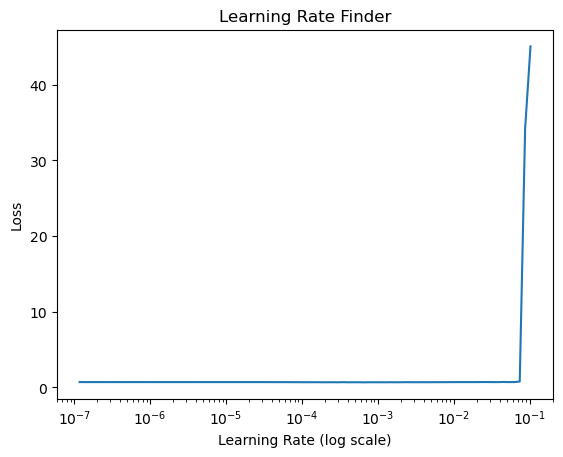

In [23]:
plt.title("Learning Rate Finder")
plt.ylabel("Loss")
plt.xlabel("Learning Rate (log scale)")
plt.plot(lrs[:85], losses[:85])
plt.xscale('log')

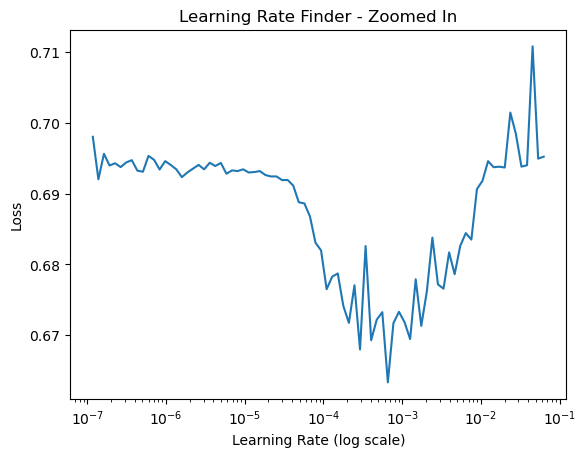

In [29]:
plt.title("Learning Rate Finder - Zoomed In")
plt.ylabel("Loss")
plt.xlabel("Learning Rate (log scale)")
plt.plot(lrs[:82], losses[:82])
plt.xscale('log')

#### Training with Best LR

In [31]:
# Define hyperparameters
BATCH_SIZE = 24
EPOCHS = 60
LEARNING_RATE = 0.0006
WEIGHT_DECAY = 1e-2
WORKERS = int(os.cpu_count())

In [32]:
# from transformers import get_linear_schedule_with_warmup
# Initialize Model
model = MorganBioBertClassification(unfreeze=False)

# Continue training
model = model.to(device)
# checkpoint = torch.load("models/checkpoint.pth.tar")
# model.load_state_dict(checkpoint['state_dict'])

# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
# optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min = 5e-6)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1*T_max, num_training_steps=T_max)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
## Define train function
def train(train_loader, model, criterion, optimizer, verbose=True):
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        target = data[2].float().to(device)   # 1 head
        # target = data[2].to(device, dtype = torch.long)   # 2 heads
        morgan_embedding = data[3].to(device)
    
        # compute output
        output = model(input_ids=ids, 
                       attention_mask=mask,
                       morgan_embedding=morgan_embedding
                      )

        # compute loss
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches
        total_loss += loss.item()

        # Report progress every 200 batches
        if step % 1000 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                step,
                len(train_loader),
                loss.item(),
                format_time(time.time() - t0)))

        # compute gradient and do SGD
        # backprop!
        loss.backward()

        # update the weights!
        optimizer.step()

        # update learning rate with scheduler
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    elapsed_time = time.time() - t0
    if verbose:
        print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
            avg_train_loss,
            format_time(elapsed_time)
        ))

    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time

In [34]:
## Define validate function
def validate(val_loader, model, criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for step, data in enumerate(val_loader):

            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            target = data[2].float().to(device)
            morgan_embedding = data[3].to(device)
        
            # compute output
            output = model(input_ids=ids, 
                           attention_mask=mask,
                           morgan_embedding=morgan_embedding
                          )

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 1000 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step,
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
        print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
            avg_val_loss,
            format_time(elapsed_time)
        ))

    return outputs, targets, avg_val_loss, elapsed_time


In [35]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
def compute_metrics(outputs, targets, prefix="Training"):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_score = np.array(outputs)
    y_true = np.array(targets)

    f2 =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")

    return y_true, y_score, y_pred, accuracy_macro

In [36]:
os.environ["TOKENIZERS_PARALLELISM"] = "TRUE"

In [37]:
filename = "models/checkpoint.pth.tar"

def save_checkpoint(state, is_best, filename=filename):
    torch.save(state, filename)

    if is_best:
        shutil.copyfile(filename, 'models/model_best.pth.tar')


In [ ]:
# Test LR = 6e-4, Optim = AdamW. Start Training
# Store the average loss after each epoch so we can plot them.
best_accuracy = 0
train_loss_values = []
val_loss_values = []
learning_rates = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print('Learning rate:', str(scheduler.get_last_lr()[0]))
    print()
    learning_rates.append(scheduler.get_last_lr())

    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred, val_accuracy = compute_metrics(val_outputs, val_targets, prefix="Validation")
    print()

    # Get the best loss
    is_best = val_accuracy > best_accuracy
    best_accuracy = max(val_accuracy, best_accuracy)

    # Save Checkpoint
    save_checkpoint(
        {'epoch': epoch+1,
         'state_dict': model.state_dict(),
         'best_accuracy': best_accuracy,
         'optimizer': optimizer.state_dict()
         },
        is_best
    )

    if train_loss < 0.2:
        break

######  Epoch 1/60 ######
Learning rate: 0.0006

-----  Training -----
Batch 1,000  of  12,462.  Loss 0.6977  Elapsed: 0:03:54.
Batch 2,000  of  12,462.  Loss 0.6562  Elapsed: 0:07:45.
Batch 3,000  of  12,462.  Loss 0.6287  Elapsed: 0:11:36.
Batch 4,000  of  12,462.  Loss 0.7117  Elapsed: 0:15:27.
Batch 5,000  of  12,462.  Loss 0.7106  Elapsed: 0:19:20.
Batch 6,000  of  12,462.  Loss 0.6296  Elapsed: 0:23:12.
Batch 7,000  of  12,462.  Loss 0.7142  Elapsed: 0:27:04.
Batch 8,000  of  12,462.  Loss 0.7169  Elapsed: 0:30:56.
Batch 9,000  of  12,462.  Loss 0.5927  Elapsed: 0:34:47.
Batch 10,000  of  12,462.  Loss 0.6495  Elapsed: 0:38:39.
Batch 11,000  of  12,462.  Loss 0.7019  Elapsed: 0:42:30.
Batch 12,000  of  12,462.  Loss 0.5417  Elapsed: 0:46:20.

Avg Training Loss 0.6506, Completed in 0:48:10 

-----  Validation -----
Batch 1,000  of  1,249.  Loss 0.6330  Elapsed: 0:03:32.

Avg Validation Loss 0.6623, Completed in 0:04:27
Validation F2-score: 0.5917
Validation Matthew Correlation Coe

In [ ]:
# Test LR = 6e-4, Optim = AdamW. Continue Training
# Store the average loss after each epoch so we can plot them.

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+48, EPOCHS+47))
    print('Learning rate:', str(scheduler.get_last_lr()[0]))
    print()
    learning_rates.append(scheduler.get_last_lr())

    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred, val_accuracy = compute_metrics(val_outputs, val_targets, prefix="Validation")
    print()

    # Get the best loss
    is_best = val_accuracy > best_accuracy
    best_accuracy = max(val_accuracy, best_accuracy)

    # Save Checkpoint
    save_checkpoint(
        {'epoch': epoch+1,
         'state_dict': model.state_dict(),
         'best_accuracy': best_accuracy,
         'optimizer': optimizer.state_dict()
         },
        is_best
    )

    if train_loss < 0.2:
        break

######  Epoch 48/107 ######
Learning rate: 5.543057123445604e-06

-----  Training -----
Batch 1,000  of  12,462.  Loss 0.4378  Elapsed: 0:03:55.
Batch 2,000  of  12,462.  Loss 0.4004  Elapsed: 0:07:47.
Batch 3,000  of  12,462.  Loss 0.4658  Elapsed: 0:11:39.
Batch 4,000  of  12,462.  Loss 0.3397  Elapsed: 0:15:32.
Batch 5,000  of  12,462.  Loss 0.4284  Elapsed: 0:19:24.
Batch 6,000  of  12,462.  Loss 0.4536  Elapsed: 0:23:17.
Batch 7,000  of  12,462.  Loss 0.6843  Elapsed: 0:27:09.
Batch 8,000  of  12,462.  Loss 0.3377  Elapsed: 0:31:01.
Batch 9,000  of  12,462.  Loss 0.2150  Elapsed: 0:34:54.
Batch 10,000  of  12,462.  Loss 0.3988  Elapsed: 0:38:46.
Batch 11,000  of  12,462.  Loss 0.3514  Elapsed: 0:42:38.
Batch 12,000  of  12,462.  Loss 0.3313  Elapsed: 0:46:29.

Avg Training Loss 0.4154, Completed in 0:48:20 

-----  Validation -----
Batch 1,000  of  1,249.  Loss 0.3646  Elapsed: 0:03:33.

Avg Validation Loss 0.5878, Completed in 0:04:29
Validation F2-score: 0.7756
Validation Matthe

In [62]:
len(train_loss_values)

73

In [63]:
len(val_loss_values)

73

In [61]:
# Test LR = 6e-4, Optim = AdamW. Continue Training
# Store the average loss after each epoch so we can plot them.

for epoch in range(37):
    print ('######  Epoch {}/{} ######'.format(epoch+64, 37+63))
    print('Learning rate:', str(scheduler.get_last_lr()[0]))
    print()
    learning_rates.append(scheduler.get_last_lr())

    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    y_val_true, y_val_score, y_val_pred, val_accuracy = compute_metrics(val_outputs, val_targets, prefix="Validation")
    print()

    # Get the best loss
    is_best = val_accuracy > best_accuracy
    best_accuracy = max(val_accuracy, best_accuracy)

    # Save Checkpoint
    save_checkpoint(
        {'epoch': epoch+1,
         'state_dict': model.state_dict(),
         'best_accuracy': best_accuracy,
         'optimizer': optimizer.state_dict()
         },
        is_best
    )

    if train_loss < 0.2:
        break

######  Epoch 64/100 ######
Learning rate: 1.2151028060331412e-05

-----  Training -----
Batch 1,000  of  12,462.  Loss 0.4773  Elapsed: 0:03:55.
Batch 2,000  of  12,462.  Loss 0.3108  Elapsed: 0:07:47.
Batch 3,000  of  12,462.  Loss 0.4578  Elapsed: 0:11:40.
Batch 5,000  of  12,462.  Loss 0.3224  Elapsed: 0:19:24.
Batch 6,000  of  12,462.  Loss 0.6009  Elapsed: 0:23:17.
Batch 7,000  of  12,462.  Loss 0.3368  Elapsed: 0:27:09.
Batch 8,000  of  12,462.  Loss 0.3681  Elapsed: 0:31:00.
Batch 9,000  of  12,462.  Loss 0.2090  Elapsed: 0:34:52.
Batch 10,000  of  12,462.  Loss 0.4705  Elapsed: 0:38:44.
Batch 11,000  of  12,462.  Loss 0.4738  Elapsed: 0:42:37.
Batch 12,000  of  12,462.  Loss 0.3065  Elapsed: 0:46:29.

Avg Training Loss 0.4160, Completed in 0:48:20 

-----  Validation -----
Batch 1,000  of  1,249.  Loss 0.3712  Elapsed: 0:03:33.

Avg Validation Loss 0.5930, Completed in 0:04:29
Validation F2-score: 0.77
Validation Matthew Correlation Coefficient: 0.4094
Validation Recall: 0.778

KeyboardInterrupt: 

### Evaluation

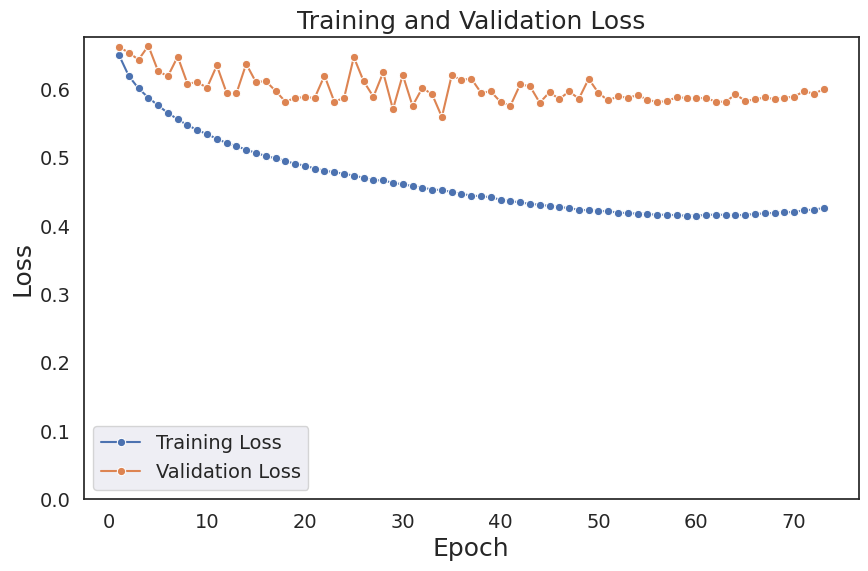

In [64]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 61), 'Training Loss': train_loss_values[:60], 'Validation Loss': val_loss_values[:60]}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)
ax.set_ylim(0)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [77]:
# Predicting with Test Set # Best Acc
checkpoint = torch.load("models/model_best_pathway.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

print('Evaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=True)
print()
y_test_true, y_test_score, y_test_pred, test_accuracy = compute_metrics(test_outputs, test_targets, prefix="Testing")

Evaluation metrics for Test Set:
Batch 1,000  of  8,326.  Loss 0.4762  Elapsed: 0:03:32.
Batch 2,000  of  8,326.  Loss 1.0880  Elapsed: 0:07:03.
Batch 3,000  of  8,326.  Loss 0.7329  Elapsed: 0:10:34.
Batch 4,000  of  8,326.  Loss 0.5348  Elapsed: 0:14:04.
Batch 5,000  of  8,326.  Loss 0.6259  Elapsed: 0:17:35.
Batch 6,000  of  8,326.  Loss 0.5026  Elapsed: 0:21:04.
Batch 7,000  of  8,326.  Loss 0.3987  Elapsed: 0:24:34.
Batch 8,000  of  8,326.  Loss 0.6313  Elapsed: 0:28:05.

Avg Validation Loss 0.5967, Completed in 0:29:17

Testing F2-score: 0.7966
Testing Matthew Correlation Coefficient: 0.3821
Testing Recall: 0.8031
Testing Precision: 0.7716
Testing Accuracy: 0.7206


In [71]:
# Predicting with Test Set # Epoch 30
checkpoint = torch.load("models/checkpoint-epoch30-pathway.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

print('Evaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=True)
print()
y_test_true, y_test_score, y_test_pred, test_accuracy = compute_metrics(test_outputs, test_targets, prefix="Testing")

Evaluation metrics for Test Set:
Batch 1,000  of  8,326.  Loss 0.3863  Elapsed: 0:03:32.
Batch 2,000  of  8,326.  Loss 0.3662  Elapsed: 0:07:02.
Batch 3,000  of  8,326.  Loss 0.3683  Elapsed: 0:10:31.
Batch 4,000  of  8,326.  Loss 0.4826  Elapsed: 0:14:01.
Batch 5,000  of  8,326.  Loss 0.3874  Elapsed: 0:17:31.
Batch 6,000  of  8,326.  Loss 0.4572  Elapsed: 0:21:02.
Batch 7,000  of  8,326.  Loss 0.3282  Elapsed: 0:24:32.
Batch 8,000  of  8,326.  Loss 0.5780  Elapsed: 0:28:02.

Avg Validation Loss 0.5993, Completed in 0:29:14

Testing F2-score: 0.8314
Testing Matthew Correlation Coefficient: 0.3326
Testing Recall: 0.86
Testing Precision: 0.7341
Testing Accuracy: 0.7097


In [65]:
# Predicting with Test Set # Epoch 47
checkpoint = torch.load("models/checkpoint-epoch47-pathway.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

print('Evaluation metrics for Test Set:')
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=True)
print()
y_test_true, y_test_score, y_test_pred, test_accuracy = compute_metrics(test_outputs, test_targets, prefix="Testing")

Evaluation metrics for Test Set:
Batch 1,000  of  8,326.  Loss 0.3821  Elapsed: 0:03:32.
Batch 2,000  of  8,326.  Loss 0.2692  Elapsed: 0:07:02.
Batch 3,000  of  8,326.  Loss 0.6311  Elapsed: 0:10:31.
Batch 4,000  of  8,326.  Loss 0.7170  Elapsed: 0:14:00.
Batch 5,000  of  8,326.  Loss 0.7218  Elapsed: 0:17:30.
Batch 6,000  of  8,326.  Loss 0.7592  Elapsed: 0:21:00.
Batch 7,000  of  8,326.  Loss 0.3024  Elapsed: 0:24:30.
Batch 8,000  of  8,326.  Loss 0.5149  Elapsed: 0:28:00.

Avg Validation Loss 0.5959, Completed in 0:29:11

Testing F2-score: 0.8204
Testing Matthew Correlation Coefficient: 0.3774
Testing Recall: 0.8375
Testing Precision: 0.7585
Testing Accuracy: 0.7241


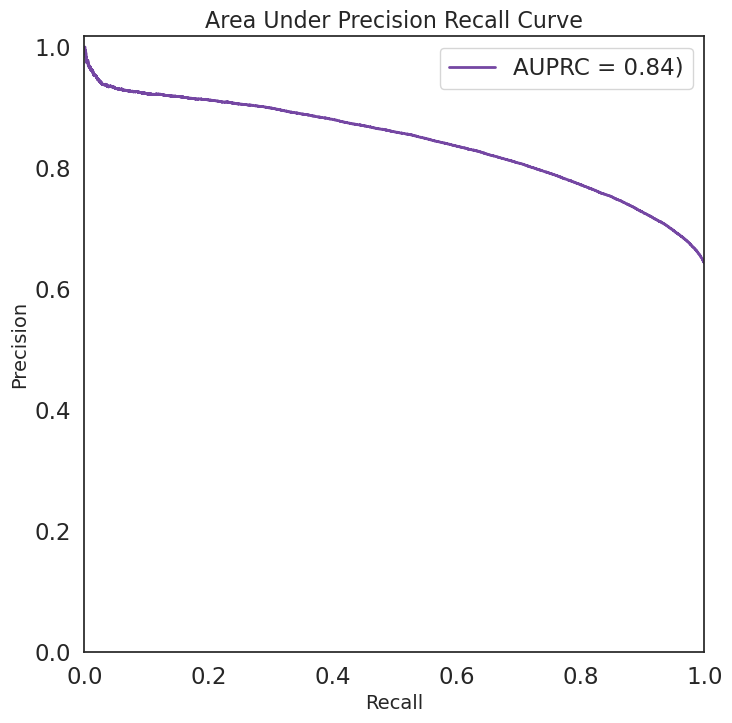

In [78]:
# Extract AUPRC & AP # Best Model
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 2)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.xlim((0, 1))
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test_true, y_test_score)

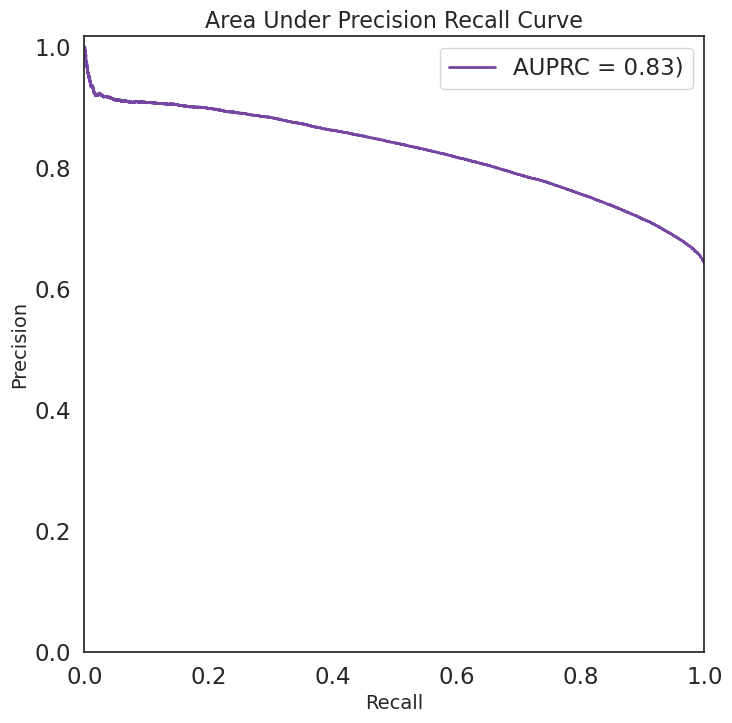

In [74]:
# Predicting with Test Set # Epoch 30
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 2)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.xlim((0, 1))
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    
plot_AUPRC(y_test_true, y_test_score)

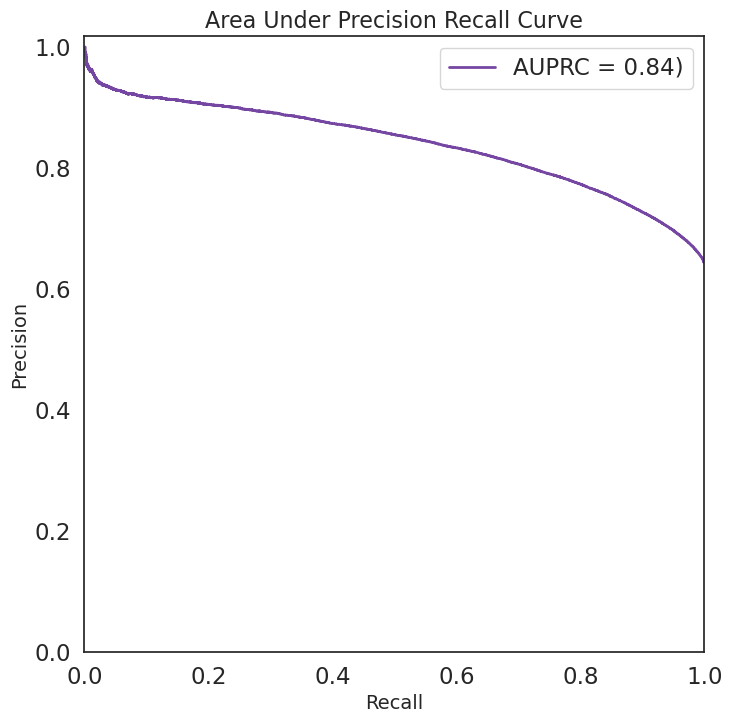

In [66]:
# Predicting with Test Set # Epoch 47
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=2, alpha=0.9,
             label=f'AUPRC = {round(auprc, 2)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.xlim((0, 1))
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()
    
plot_AUPRC(y_test_true, y_test_score)

In [47]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test_true, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.61      0.58      0.59     71366
     class 1       0.77      0.80      0.78    128451

    accuracy                           0.72    199817
   macro avg       0.69      0.69      0.69    199817
weighted avg       0.71      0.72      0.72    199817



In [79]:
# Predicting with Test Set # Best Model
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[57.21211782, 42.78788218],
       [19.687663  , 80.312337  ]])

In [75]:
# Predicting with Test Set # Epoch 30
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
# conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[ 31358,  40008],
       [ 17989, 110462]])

In [69]:
# Predicting with Test Set # Epoch 47
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
# conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

array([[ 37114,  34252],
       [ 20879, 107572]])

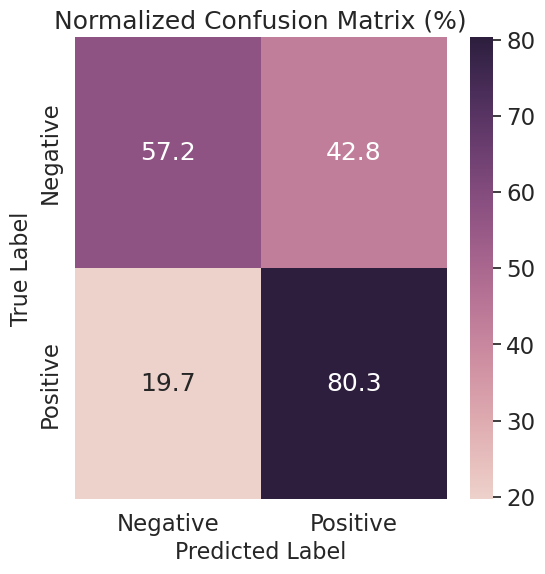

In [80]:
# Predicting with Test Set # Best Model
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        # fmt=',.0f'
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Normalized Confusion Matrix (%)", fontsize=18)
    plt.show()

# conf_matrix = np.array([[56.60053723, 43.39946277],[15.35019128, 84.64980872]])
plot_conf_matrix_high(conf_matrix)

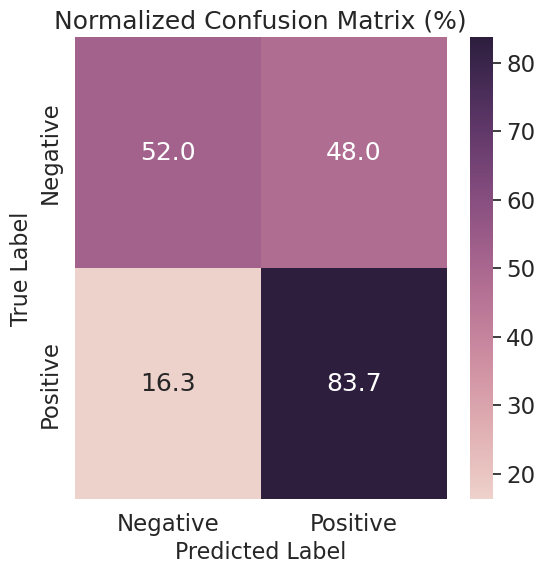

In [68]:
# Predicting with Test Set # Epoch 47
def plot_conf_matrix_normalize(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        # fmt=',.0f'
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Normalized Confusion Matrix (%)", fontsize=18)
    plt.show()

plot_conf_matrix_normalize(conf_matrix)

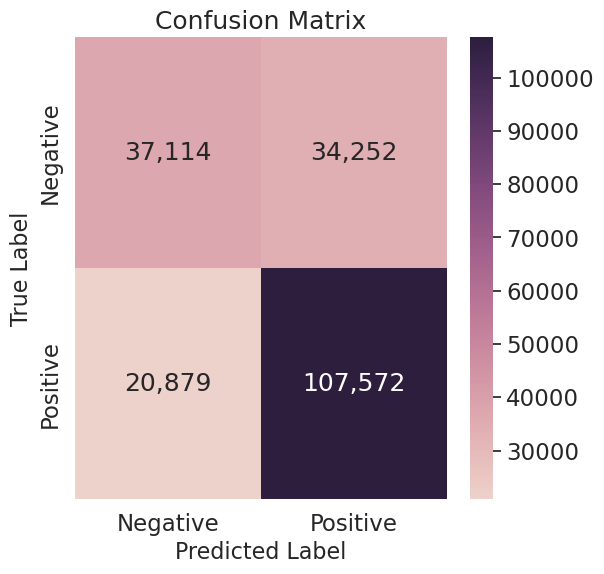

In [70]:
# Predicting with Test Set # Epoch 47
def plot_conf_matrix(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Negative', 'Positive'],
        yticklabels= ['Negative', 'Positive'],
        fmt=',.0f'
    )
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Confusion Matrix", fontsize=18)
    
    plt.show()

plot_conf_matrix(conf_matrix)

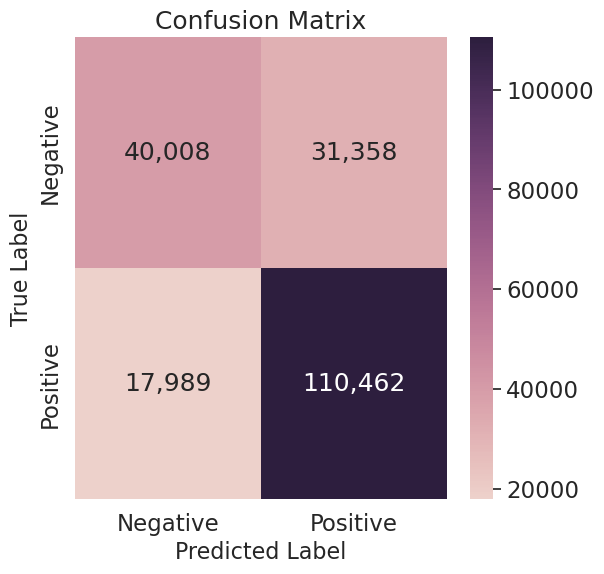

In [76]:
# Predicting with Test Set # Epoch 30
conf_matrix = np.array([[40008, 31358], [ 17989, 110462]])
plot_conf_matrix(conf_matrix)

## Export Best Model Weight For CPU inference

In [7]:
# Load Best Model
model = MorganBioBertClassification()
model = model.to(device)
checkpoint = torch.load("models/checkpoint-epoch47-pathway.pth.tar")
model.load_state_dict(checkpoint['state_dict'])

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [8]:
model = model.to('cpu')
filename = "models/morgan-bioclinicalbert-pathway-cpu.pth.tar"
state = {'epoch': 47,
         'state_dict': model.state_dict()}

torch.save(state, filename)